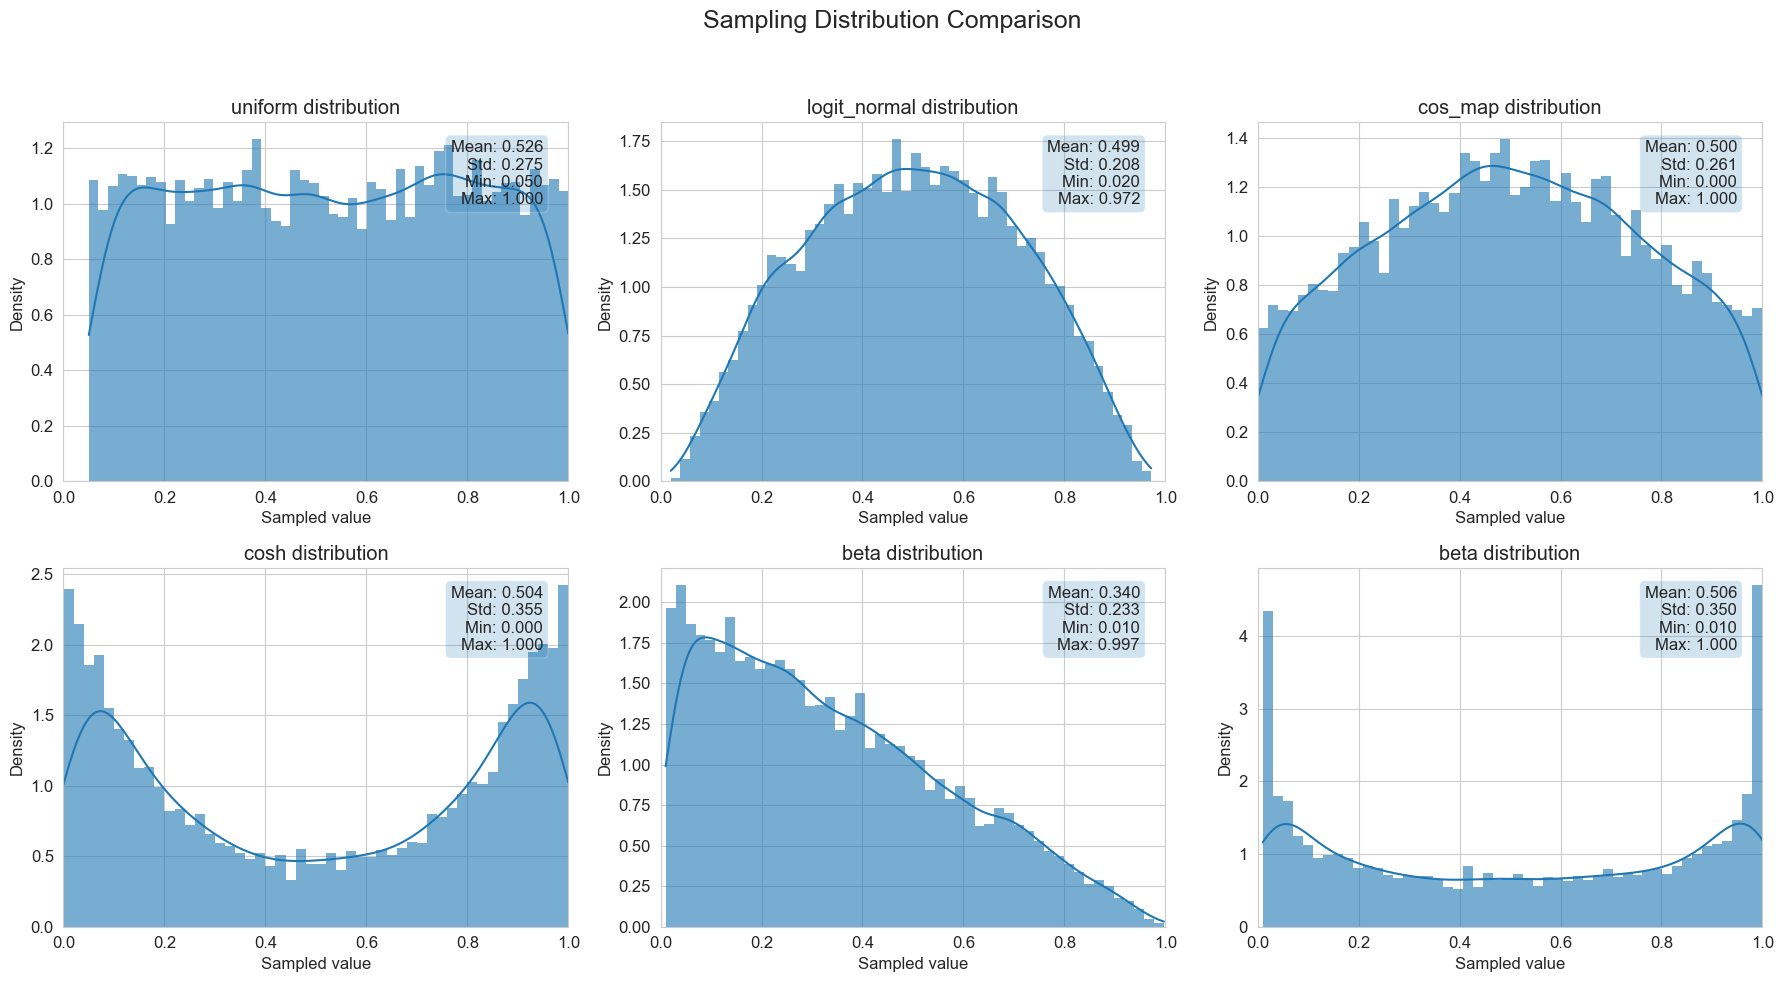

In [8]:
import torch
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.special import expit

# 配置Seaborn样式
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

class Sampler:
    def __init__(self, sample_method, sample_params=None, eps=0.01):
        self.sample_method = sample_method
        self.sample_params = sample_params or {}
        self.eps = eps
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    def sample(self, shape=(10000,)):
        if self.sample_method == 'uniform':
            t = torch.rand(shape, device=self.device) * (1 - self.eps) + self.eps
            return t.cpu().numpy()
        
        elif self.sample_method == 'logit_normal':
            t = torch.randn(shape, device=self.device)
            t = math.sqrt(self.sample_params.get('s', 1.0)) * t + self.sample_params.get('m', 0.0)
            t = 1 / (1 + torch.exp(-t))
            return t.cpu().numpy()
        
        elif self.sample_method == 'cos_map':
            u = torch.rand(shape, device=self.device)
            t = 1 - 1 / (torch.tan(0.5 * math.pi * u) + 1)
            return t.cpu().numpy()
        
        elif self.sample_method == 'cosh':
            alpha = self.sample_params.get('alpha', 5.0)
            mu = self.sample_params.get('mu', 0.5)
            u = torch.rand(shape, device=self.device)
            Z_0 = (math.sinh(alpha * (1 - mu)) + math.sinh(alpha * mu)) / alpha
            w = (alpha * Z_0 * u - math.sinh(alpha * mu)) + \
                torch.sqrt((alpha * Z_0 * u - math.sinh(alpha * mu))**2 + 1)
            t = torch.log(w) / alpha + mu
            return t.cpu().numpy()
        
        elif self.sample_method == 'beta':
            alpha = self.sample_params.get('alpha', 2.0)
            beta = self.sample_params.get('beta', 5.0)
            t = torch.distributions.Beta(alpha, beta).sample(shape)
            t = self.eps + (1 - self.eps) * t
            return t.cpu().numpy()

# 创建可视化函数
def visualize_sampler(sampler, ax):
    data = sampler.sample()
    
    sns.histplot(data, bins=50, stat='density', alpha=0.6, ax=ax, kde=True,
                edgecolor='none')
    
    # 添加统计信息
    ax.annotate(f'Mean: {np.mean(data):.3f}\nStd: {np.std(data):.3f}\nMin: {np.min(data):.3f}\nMax: {np.max(data):.3f}',
                xy=(0.95, 0.95), xycoords='axes fraction',
                ha='right', va='top',
                bbox=dict(boxstyle='round', alpha=0.2))
    
    ax.set_xlim(0, 1)
    ax.set_title(f'{sampler.sample_method} distribution')
    ax.set_xlabel('Sampled value')

# 创建多子图对比
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Sampling Distribution Comparison', fontsize=18)

# Uniform 分布
sampler = Sampler('uniform', eps=0.05)
visualize_sampler(sampler, axes[0, 0])

# Logit-Normal 分布
sampler = Sampler('logit_normal', {'m': 0.0, 's': 1.0})
visualize_sampler(sampler, axes[0, 1])

# Cos Map 分布
sampler = Sampler('cos_map')
visualize_sampler(sampler, axes[0, 2])

# Cosh 分布
sampler = Sampler('cosh', {'alpha': 5.0, 'mu': 0.5})
visualize_sampler(sampler, axes[1, 0])

# Beta 分布 (默认参数)
sampler = Sampler('beta', {'alpha': 1.0, 'beta': 2.0})
visualize_sampler(sampler, axes[1, 1])

# Beta 分布 (对称形状)
sampler = Sampler('beta', {'alpha': 0.5, 'beta': 0.5})
visualize_sampler(sampler, axes[1, 2])

# 调整布局并显示
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()